# Gmsh2OPS: Case 1

This case primarily uses the ``dimension`` and ``entity`` ID information from ``GMSH`` to convert the model into an OpenSees format. Refer to the dimensions and entity IDs in [Elementary entities vs. physical groups](https://gmsh.info/doc/texinfo/gmsh.html#Elementary-entities-vs-physical-groups):

In [1]:
import opstool as opst
import openseespy.opensees as ops
import gmsh

In [2]:
gmsh.initialize()  # Initialize

# Create rectangles with entity tags 1 and 2, the function returns entity IDs
rect1 = gmsh.model.occ.addRectangle(x=0, y=0, z=0, dx=2, dy=3, tag=1)
rect2 = gmsh.model.occ.addRectangle(x=2, y=0, z=0, dx=2, dy=3, tag=2)
# Remove duplicate entities, ensuring overlapping edges between the two rectangles are kept as one
gmsh.model.occ.removeAllDuplicates()
# Synchronize the current Gmsh model, this step is mandatory
gmsh.model.occ.synchronize()

# Get the boundary lines of the two rectangles; dimTags identifies the dimension and entity
lines1 = gmsh.model.getBoundary(dimTags=[(2, rect1)], oriented=False)
lines2 = gmsh.model.getBoundary(dimTags=[(2, rect2)], oriented=False)

# Set mesh division seeds: constrain each boundary line of the rectangles to generate 21 nodes
# Since curves are inherently 1D, only entity IDs are required without specifying dimensions
for l in lines1:
    gmsh.model.mesh.setTransfiniteCurve(tag=l[1], numNodes=21)
for l in lines2:
    gmsh.model.mesh.setTransfiniteCurve(tag=l[1], numNodes=21)
# Constrain mesh generation for the plane as well to ensure internal regularity
# Planes are inherently 2D, so only entity IDs are needed
gmsh.model.mesh.setTransfiniteSurface(tag=rect1)
gmsh.model.mesh.setTransfiniteSurface(tag=rect2)

# Set mesh algorithm, enable RecombineAll (1 for enabling), merging triangular meshes into quadrilateral ones
gmsh.option.setNumber("Mesh.RecombineAll", 1)
gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)

# Generate the mesh; since it's for surfaces, dim=2
gmsh.model.mesh.generate(dim=2)

# By default, GMSH generates first-order elements; change the mesh on surface 2 to second-order (nine-node quadrilaterals)
# First, hide surface 1 by setting its visibility to 0
gmsh.option.setNumber("Mesh.MeshOnlyVisible", 1)
gmsh.model.setVisibility(dimTags=[(2, 1)], value=0, recursive=True)
# Then, set the mesh order for all currently visible objects to 2
gmsh.model.mesh.setOrder(2)
# Reactivate surface 1
gmsh.model.setVisibility(dimTags=[(2, 1)], value=1, recursive=True)

# Write the mesh to a file
# gmsh.write("t1.msh")

# Launch the GUI for visualization
# gmsh.fltk.run()

In [3]:
ops.wipe()
# Initialize a basic 3D model with 6 degrees of freedom per node
ops.model("basic", "-ndm", 3, "-ndf", 6)

# Define an elastic isotropic material
# Material ID: 1
# Elastic modulus: 2e8
# Poisson's ratio: 0.3
# Density: 7.85
ops.nDMaterial("ElasticIsotropic", 1, 2e8, 0.3, 7.85)

# Define a section using PlateFiber
# Section tag: 1
# Material tag: 1 (linked to the material defined above)
# Thickness: 0.005
secTag = 1
ops.section("PlateFiber", secTag, 1, 0.005)

In [4]:
# Initialize GMSH to OpenSeesPy converter with 3D model and 6 degrees of freedom per node
GMSH2OPS = opst.pre.Gmsh2OPS(ndm=3, ndf=6)

# Read the saved .msh file generated by GMSH
# GMSH2OPS.read_gmsh_file("t1.msh")
GMSH2OPS.read_gmsh_data()
# Finalize and close
gmsh.finalize()

# Create OpenSeesPy node commands based on all nodes defined in the GMSH file
GMSH2OPS.create_node_cmds()

# Create OpenSeesPy element commands for specific entities
# ShellMITC4 elements (4-node shell elements)
ele_tags_n4 = GMSH2OPS.create_element_cmds(
    ops_ele_type="ShellMITC4",  # OpenSeesPy element type
    ops_ele_args=[secTag],  # Additional arguments for the element (e.g., section tag)
    dim_entity_tags=[
        (2, 1)
    ],  # Dimension-entity tags to specify which elements to create
)

# ShellMITC9 elements (9-node shell elements)
ele_tags_n9 = GMSH2OPS.create_element_cmds(
    ops_ele_type="ShellMITC9",  # OpenSeesPy element type for 9-node shells
    ops_ele_args=[secTag],  # Additional arguments for the element (e.g., section tag)
    dim_entity_tags=[
        (2, 2)
    ],  # Dimension-entity tags to specify which elements to create
)
# Done!

Info:: Geometry Information >>>
15 Entities: 6 Point; 7 Curves; 2 Surfaces; 0 Volumes.

Info:: Physical Groups Information >>>
0 Physical Groups.
Physical Group names: []

Info:: Mesh Information >>>
2101 Nodes; MaxNodeTag 2101; MinNodeTag 1.
946 Elements; MaxEleTag 946; MinEleTag 1.



Using ShellMITC9 - Developed by: Leopoldo Tesser and Diego A. Talledo


In [5]:
# Define boundary conditions
# Get the boundary dimension tags for the two surfaces
boundary_dim_tags = GMSH2OPS.get_boundary_dim_tags([(2, 1), (2, 2)])

# Remove the shared boundary between the two surfaces
boundary_dim_tags.remove((1, 2))

# Print the remaining boundary dimension tags
print("Boundary dim_tags:", boundary_dim_tags)

# Create fix commands for the boundary with constraints applied to all 6 degrees of freedom (DOFs)
fix_node_tags = GMSH2OPS.create_fix_cmds(
    dim_entity_tags=boundary_dim_tags, dofs=[1] * 6
)

Boundary dim_tags: [(0, 1), (0, 4), (1, 5), (1, 1), (0, 3), (1, 4), (0, 6), (0, 2), (1, 7), (0, 5), (1, 6), (1, 3)]


OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

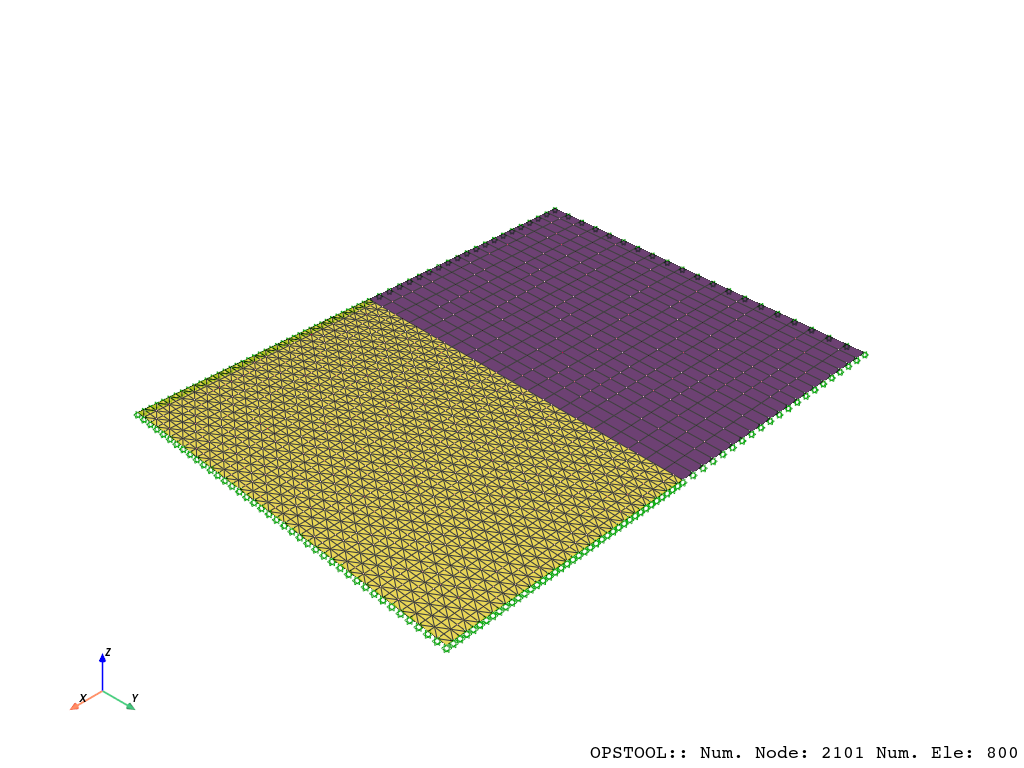

In [6]:
opst.vis.pyvista.set_plot_props(
    point_size=0, notebook=True, mesh_opacity=0.75, cmap_model="viridis"
)
plotter = opst.vis.pyvista.plot_model()
plotter.show(jupyter_backend="jupyterlab")
# plotter.show()

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-None.nc!

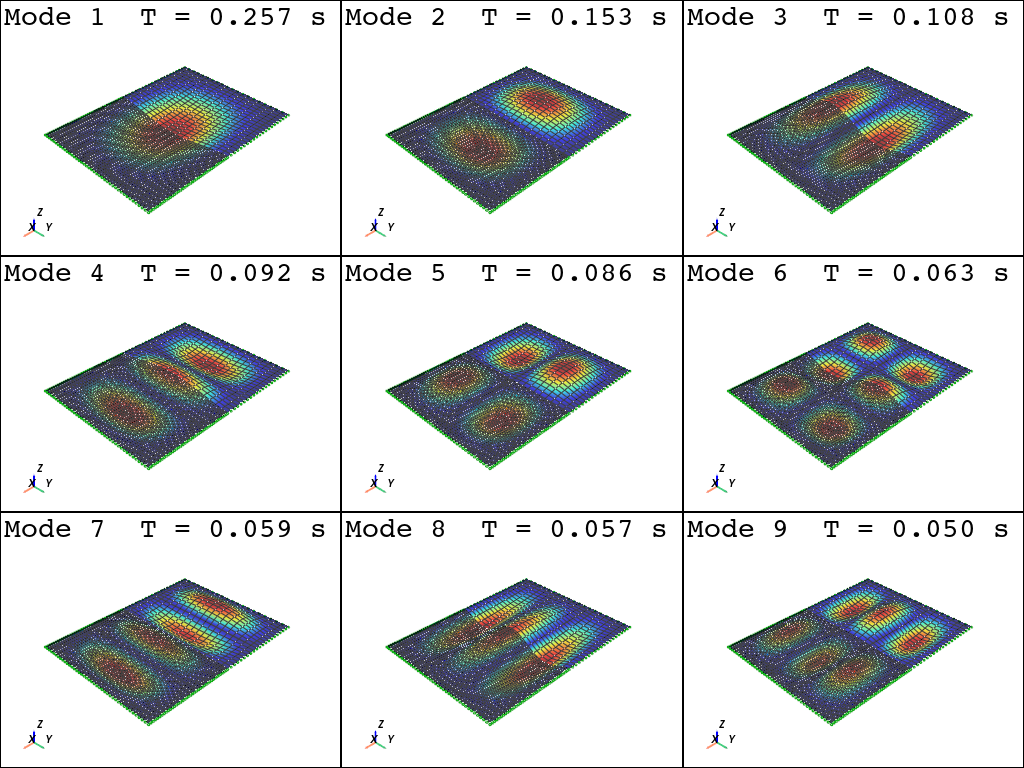

In [7]:
plotter = opst.vis.pyvista.plot_eigen([1, 9], subplots=True)
plotter.show(jupyter_backend="jupyterlab")
# plotter.show()